# Libraries

In [1]:
import keras
from keras.preprocessing import image as kimage
from keras.applications import mobilenet_v2, densenet
from sklearn.neighbors import KDTree
import joblib
import cv2 as cv
from matplotlib import pyplot as plt
import numpy as np
from time import time
import os

Using TensorFlow backend.


In [2]:
from tqdm.notebook import tqdm

In [3]:
import IPython.display as ipd

In [4]:
# Imports for face alignment
# How to install:
#    pip install imutils
#    conda install -c conda-forge dlib  
import imutils
from imutils.face_utils import FaceAligner
from imutils.face_utils import rect_to_bb
import dlib

In [5]:
import sys
sys.path.insert(1, '../Images')
import utils_2d

In [6]:
detector = dlib.get_frontal_face_detector()
predictor = dlib.shape_predictor("../Images/shape_predictor_68_face_landmarks.dat")
fa = FaceAligner(predictor, desiredFaceWidth=224)

## Load model

In [7]:
mobilenet_model = mobilenet_v2.MobileNetV2(include_top=False, weights='imagenet',
                                           pooling='max', input_shape=(224, 224, 3))

In [8]:
def mobilenet_preprocessing(img):
    img = img[:,:,::-1].astype('uint8')
    gray = cv.cvtColor(img, cv.COLOR_BGR2GRAY)
    faces = detector(gray, 2)
    if len(faces)>0:
        img = fa.align(img, gray, faces[0])[:,:,::-1]
    elif img.shape != (224, 224, 3):
        img = cv.resize(img, (224, 224))[:,:,::-1]
    img = mobilenet_v2.preprocess_input(img)
    return img

## Load Features Functions

In [9]:
def compute_features(img, model, preprocessing):
    img = kimage.img_to_array(img)
    img = preprocessing(img)
    if len(img.shape) == 3:
        x = img[np.newaxis, :,:,:]
    else:
        x = img[np.newaxis,:,:,np.newaxis] 
    f = model.predict(x)
    return f.flatten()

In [10]:
# Data loader
def load_data(base_path, model, preprocessing, pics_per_person=3, color_mode = "rgb",
              target_size=(224,224), file_formats=["png", "jpg"], folders = None, np_seed = 0):

    paths = []
    features = []
    if folders is None:
        folders = os.listdir(base_path)
    for folder in tqdm(folders):
        #print(folder)
        path = base_path + "/" + folder
        if os.path.isdir(path):
            filenames = os.listdir(path)
            np.random.seed(np_seed)
            random_filenames = np.random.choice(filenames,
                                                np.min([len(filenames), pics_per_person]),
                                                replace=False)
            for f in sorted(random_filenames):
                if (f[-3:] in file_formats):
                    # Memorizza percorso file
                    cur_path = path+"/" + f
                    paths.append(cur_path)
                    # Carica file ed estraine le features
                    image = kimage.load_img(cur_path, target_size=(224, 224), color_mode = color_mode)
                    cur_features = compute_features(image, model, preprocessing)
                    features.append(cur_features)

    features = np.array(features)
    return features, np.array(paths)

# Retrieval - Celebrities pictures

In [11]:
path = "celebrities_full/"

In [12]:
classes = sorted(os.listdir(path))

In [13]:
len(classes)

1580

In [14]:
classes[:5]

['50 cent', 'aamir khan', 'aaron carter', 'aaron eckhart', 'abhishek bachchan']

There are 1580 classes.

We are going to compute features for 50 random pictures for each class.

In [15]:
pics_per_person = 20

We discard classes with less than 20 pictures:

In [16]:
classes = [cls for cls in classes if len(os.listdir(path+cls)) >= pics_per_person]

In [17]:
len(classes)

1569

In [18]:
classes[:5]

['50 cent', 'aamir khan', 'aaron carter', 'aaron eckhart', 'abhishek bachchan']

In [19]:
# %%time
# mobilenet_X_train, paths = load_data(path, mobilenet_model, mobilenet_preprocessing,
#                                   pics_per_person=pics_per_person, folders=classes)

We save the features and paths:

In [20]:
# np.save("features/mobilenet_paths_20ppp_crop", mobilenet_X_train)
# np.save("features/mobilenet_X_train_20ppp_crop", paths)

In [21]:
paths = np.load("features/mobilenet_paths_20ppp_crop.npy")
mobilenet_X_train = np.load("features/mobilenet_X_train_20ppp_crop.npy")

## Albero di ricerca

In [22]:
mobilenet_X_train.shape

(29829, 1280)

In [23]:
%%time
tree = KDTree(mobilenet_X_train)

CPU times: user 2.67 s, sys: 24.4 ms, total: 2.69 s
Wall time: 2.69 s


In [24]:
def plot_imgs(paths, ind, n_imgs = 10, title = None):
    
    Tot = n_imgs
    Cols = 5
    Rows = Tot // Cols
    Rows += Tot % Cols
    Position = range(1,Tot + 1)
    
    fig = plt.figure(figsize = (15,3 * Rows))
    # fig = plt.figure()
    fig.tight_layout()
    if title is not None:
        fig.suptitle(title, fontsize=16)
    for i in range(n_imgs):
        path = paths[ind[0][i]]
        vip_name = path.split("/")[-2]
        img=kimage.load_img(paths[ind[0][i]])
        
        ax = fig.add_subplot(Rows,Cols,Position[i])
        ax.axis('off')
        ax.set_title(f"{i+1}: {vip_name}")
        ax.imshow(img)
    # plt.subplots_adjust(wspace=0, hspace=0)
    plt.show()

## Example Query #1

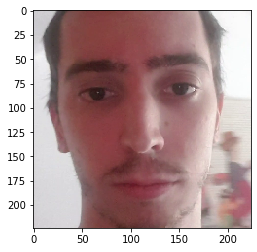

In [25]:
test_dir = "../Images/test_pictures/"
img =  kimage.load_img(test_dir+"gian/gian_6.png", target_size=(224, 224))

plt.imshow(img)
plt.show()

Trasformo l'immagine:

In [26]:
%time
query_features = compute_features(kimage.img_to_array(img), mobilenet_model, mobilenet_preprocessing)

CPU times: user 3 µs, sys: 1e+03 ns, total: 4 µs
Wall time: 7.15 µs


Interrogo l'albero di ricerca

In [27]:
%%time
dist, ind = tree.query(query_features.reshape(1, -1), k=10)

CPU times: user 435 ms, sys: 897 ms, total: 1.33 s
Wall time: 173 ms


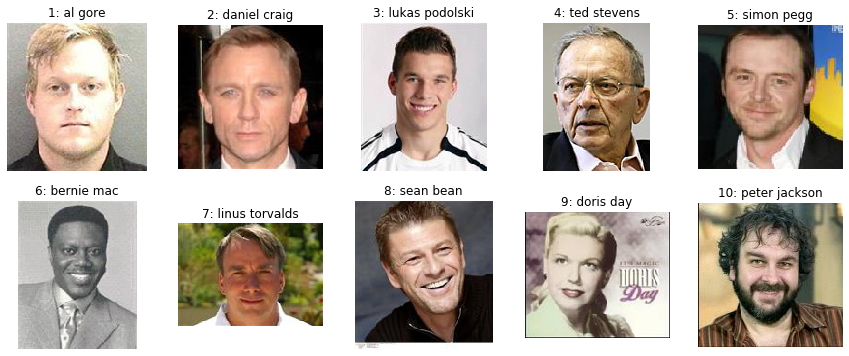

In [28]:
plot_imgs(paths, ind)

## Query #2

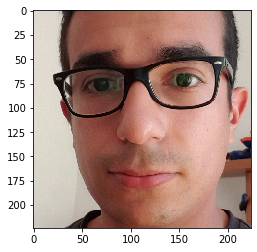

In [29]:
test_dir = "../Images/test_pictures/"
img =  kimage.load_img(test_dir+"khaled/khaled_1.png", target_size=(224, 224))

plt.imshow(img)
plt.show()

Trasformo l'immagine:

Interrogo l'albero di ricerca

In [30]:
%time
query_features = compute_features(kimage.img_to_array(img), mobilenet_model, mobilenet_preprocessing)
dist, ind = tree.query(query_features.reshape(1, -1), k=10)

CPU times: user 11 µs, sys: 0 ns, total: 11 µs
Wall time: 14.1 µs


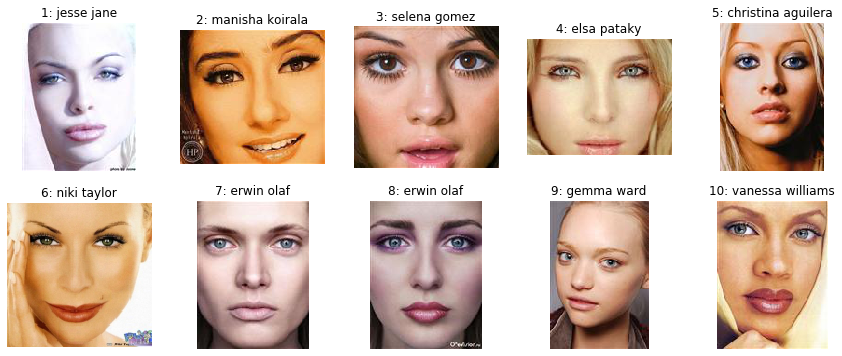

In [31]:
plot_imgs(paths, ind)

# Query all pictures for each person

We now query all pictures for:

- Alessandro,
- Alinda,
- Cami,
- Gian,
- Khaled,
- Luca,
- Mamma,
- Papi,

take the mode of the first ten retrieved celebrities, and count how many times each celebrity is considered the most similar.

In [32]:
from scipy.stats import mode

In [33]:
def query_all_pictures(cls, classes, model, preprocessing, test_dir = "../Images/test_pictures/"):
    query_pictures = [test_dir+cls+"/"+f for f in os.listdir(test_dir+cls)]
    d = {}
    for cel in classes:
        d[cel] = 0
    maxl = np.max([len(cel) for cel in classes ]) + 1
        
    tot = len(query_pictures)
    i = 0
    for file in query_pictures:
        i+=1
        img =  kimage.load_img(file, target_size=(224, 224))
        query_features = compute_features(kimage.img_to_array(img), model, preprocessing)
        dist, ind = tree.query(query_features.reshape(1, -1), k=10)
        predicted = np.array(paths)[ind[0]]
        predicted = [p.split("/")[-2] for p in predicted]
        if np.max(np.unique(predicted, return_counts=True)[1]) > 1:
            predicted = mode(predicted)[0][0]
        else:
            # otherwise we take the most similar
            predicted = predicted[0]
        d[predicted] += 1
        ipd.clear_output(wait=True)
        
        print(cls)
        print("Query #{}/{}\n".format(i, tot))
        
        print(f"{'':{maxl}s}  {'counts':}")
        for j in sorted(d.keys(), key = lambda x : -d[x])[:10]:
            # print("{:14s}: {:3d}, {:>02.2f}%".format(j, d[j], d[j]/i*100))
            print(f"{j:{maxl}s}: {d[j]:6d}")

In [34]:
%%time
query_all_pictures("alessandro", classes, mobilenet_model, mobilenet_preprocessing)

alessandro
Query #100/100

                        counts
emmanuelle chriqui    :     21
reese witherspoon     :     17
glenn close           :     11
liam neeson           :     10
ruslana korshunova    :      7
tom hanks             :      4
charles aznavour      :      3
maggie gyllenhaal     :      3
leonardo dicaprio     :      2
anna netrebko         :      1
CPU times: user 1min 48s, sys: 2min 46s, total: 4min 34s
Wall time: 47.2 s


In [35]:
%%time
query_all_pictures("alinda", classes, mobilenet_model, mobilenet_preprocessing)

alinda
Query #100/100

                        counts
tom hanks             :     32
rosario dawson        :      6
al gore               :      5
michael bay           :      5
glenn beck            :      4
lukas podolski        :      4
diane lane            :      3
erika sawajiri        :      3
juliette lewis        :      3
leonardo dicaprio     :      3
CPU times: user 1min 51s, sys: 2min 52s, total: 4min 43s
Wall time: 48.6 s


In [36]:
%%time
query_all_pictures("cami", classes, mobilenet_model, mobilenet_preprocessing)

cami
Query #100/100

                        counts
hilary swank          :     61
anne heche            :     11
courteney cox         :      6
olivia wilde          :      4
perez hilton          :      4
nicole richie         :      3
reese witherspoon     :      3
elizabeth banks       :      2
jon renau             :      2
hayden panettiere     :      1
CPU times: user 1min 49s, sys: 2min 49s, total: 4min 39s
Wall time: 49.1 s


In [37]:
%%time
query_all_pictures("gian", classes, mobilenet_model, mobilenet_preprocessing)

gian
Query #100/100

                        counts
dakota fanning        :     54
jesse jane            :     18
al capone             :      9
lukas podolski        :      5
al gore               :      3
leonard cohen         :      2
rosario dawson        :      2
salman khan           :      2
aya ueto              :      1
bernie mac            :      1
CPU times: user 1min 51s, sys: 2min 48s, total: 4min 40s
Wall time: 48.8 s


In [38]:
%%time
query_all_pictures("khaled", classes, mobilenet_model, mobilenet_preprocessing)

khaled
Query #100/100

                        counts
dakota fanning        :     23
erwin olaf            :     11
al franken            :     10
joan rivers           :      9
elsa pataky           :      7
steven soderbergh     :      7
cyndi lauper          :      4
doris day             :      4
gemma ward            :      4
jesse jane            :      4
CPU times: user 1min 50s, sys: 2min 44s, total: 4min 34s
Wall time: 48.1 s


In [39]:
%%time
query_all_pictures("luca", classes, mobilenet_model, mobilenet_preprocessing)

luca
Query #100/100

                        counts
dakota fanning        :     21
tom hanks             :     12
steve mcqueen         :      9
chris martin          :      7
rosario dawson        :      7
sean penn             :      7
greta garbo           :      6
madhuri dixit         :      5
john travolta         :      4
al gore               :      2
CPU times: user 1min 50s, sys: 2min 46s, total: 4min 36s
Wall time: 47.6 s


In [40]:
%%time
query_all_pictures("mamma", classes, mobilenet_model, mobilenet_preprocessing)

mamma
Query #100/100

                        counts
liam neeson           :     23
hilary swank          :      7
matt dillon           :      5
david miliband        :      4
george bush           :      4
larry king            :      4
marc jacobs           :      4
mickey rourke         :      4
al capone             :      3
ronan keating         :      3
CPU times: user 1min 47s, sys: 2min 45s, total: 4min 32s
Wall time: 46.1 s


In [41]:
%%time
query_all_pictures("papi", classes, mobilenet_model, mobilenet_preprocessing)

papi
Query #100/100

                        counts
glenn beck            :     13
axl rose              :     11
ralph nader           :      7
rosario dawson        :      7
emmanuelle chriqui    :      5
al gore               :      4
leonardo dicaprio     :      4
liam neeson           :      4
michelle williams     :      4
al capone             :      3
CPU times: user 1min 49s, sys: 2min 45s, total: 4min 34s
Wall time: 47.3 s
